<a href="https://colab.research.google.com/github/RkanGen/LLM-RAG/blob/main/Claude_3_Multimodal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Claude 3 MultimodalCookbook

Anthropic has released Claude 3. This notebook provides you to get a quick start with using the Haiku model. It helps you explore the capabilities of model on text and vision tasks.



#### Installation

In [ ]:
!pip install llama-index --quiet
!pip install llama-index-llms-anthropic --quiet
!pip install llama-index-multi-modal-llms-anthropic --quiet
!pip install llama-index-vector-stores-singlestoredb --quiet

In [ ]:
from llama_index.llms.anthropic import Anthropic
from llama_index.multi_modal_llms.anthropic import AnthropicMultiModal

#### Set API keys

In [ ]:
import os

os.environ["ANTHROPIC_API_KEY"] = ""

os.environ["OPENAI_API_KEY"] = ""

### Using Model for Chat/ Completion

In [ ]:
llm = Anthropic(model="claude-3-haiku-20240307")

In [ ]:
response = llm.complete("whatis 'Groq' and her IA chips ")
print(response)

### Using Model for Multi-Modal

##### Download image

In [ ]:
!wget 'https://raw.githubusercontent.com/run-llama/llama_index/main/docs/docs/examples/data/images/prometheus_paper_card.png' -O 'prometheus_paper_card.png'

--2024-04-04 16:35:20--  https://raw.githubusercontent.com/run-llama/llama_index/main/docs/docs/examples/data/images/prometheus_paper_card.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1002436 (979K) [image/png]
Saving to: ‘prometheus_paper_card.png’

prometheus_paper_ca 100%[===================>] 978.94K  --.-KB/s    in 0.01s   

2024-04-04 16:35:20 (80.9 MB/s) - ‘prometheus_paper_card.png’ saved [1002436/1002436]



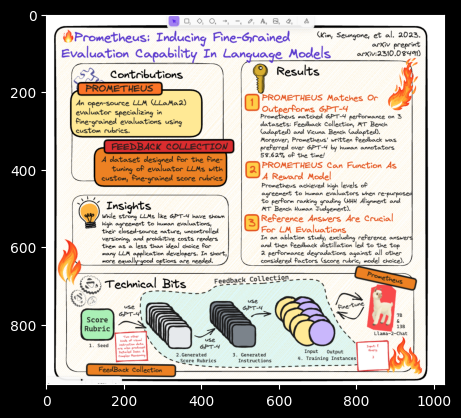

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

img = Image.open("prometheus_paper_card.png")
plt.imshow(img)

#### Load the image

In [ ]:
from llama_index.core import SimpleDirectoryReader

# put your local directore here
image_documents = SimpleDirectoryReader(
    input_files=["prometheus_paper_card.png"]
).load_data()

# Initiated Anthropic MultiModal class
anthropic_mm_llm = AnthropicMultiModal(
    model="claude-3-haiku-20240307", max_tokens=300
)

#### Test query on image

In [ ]:
response = anthropic_mm_llm.complete(
    prompt="Describe the images as an alternative text",
    image_documents=image_documents,
)

print(response)

The image is a poster titled "Prometheus: Inducing Fine-Grained Evaluation Capability In Language Models". It provides information about the Prometheus project, which is an open-source LLM (LLama2) evaluator specializing in fine-grained evaluations using custom rubrics.

The poster is divided into three main sections: Contributions, Results, and Technical Bits.

The Contributions section introduces Prometheus as an open-source LLM evaluator that uses custom rubrics for fine-grained evaluations. It also mentions the Feedback Collection dataset, which was designed for the fine-tuning of evaluator LLMs with custom, fine-grained score rubrics.

The Results section highlights three key findings: 1) Prometheus matches or outperforms GPT-4 on three datasets, and its written feedback was preferred over GPT-4 by human annotators 58.6% of the time; 2) Prometheus can function as a reward model, achieving high levels of agreement with human evaluators when re-purposed to perform ranking, grading, 

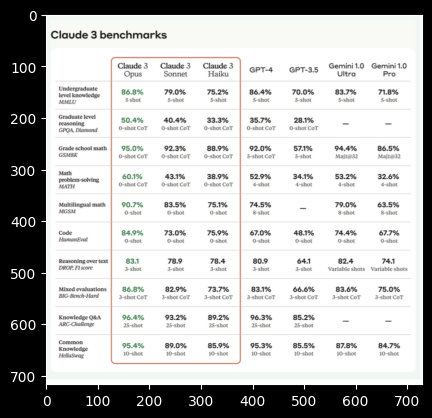

In [ ]:
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
from llama_index.core.multi_modal_llms.generic_utils import load_image_urls

image_urls = [
    "https://venturebeat.com/wp-content/uploads/2024/03/Screenshot-2024-03-04-at-12.49.41%E2%80%AFAM.png",
    # Add yours here!
]

img_response = requests.get(image_urls[0])
img = Image.open(BytesIO(img_response.content))
plt.imshow(img)

image_url_documents = load_image_urls(image_urls)

In [ ]:
response = anthropic_mm_llm.complete(
    prompt="Describe the images as an alternative text",
    image_documents=image_url_documents,
)

print(response)

## Index into a Vector Store

In this section we show you how to use Claude 3 to build a RAG pipeline over image data. We first use Claude to extract text from a set of images. We then index the text with an embedding model. Finally, we build a query pipeline over the data.

In [ ]:
from llama_index.multi_modal_llms.anthropic import AnthropicMultiModal

anthropic_mm_llm = AnthropicMultiModal(max_tokens=300)

In [ ]:
!wget "https://www.dropbox.com/scl/fi/c1ec6osn0r2ggnitijqhl/mixed_wiki_images_small.zip?rlkey=swwxc7h4qertyhmby5fsnderd&dl=1" -O mixed_wiki_images_small.zip
!unzip mixed_wiki_images_small.zip

In [ ]:
from llama_index.core.schema import TextNode
from pathlib import Path
from llama_index.core import SimpleDirectoryReader

nodes = []
for img_file in Path("mixed_wiki_images_small").glob("*.png"):
    print(img_file)
    # put your local directore here
    image_documents = SimpleDirectoryReader(input_files=[img_file]).load_data()
    response = anthropic_mm_llm.complete(
        prompt="Describe the images as an alternative text",
        image_documents=image_documents,
    )
    metadata = {"img_file": img_file}
    nodes.append(TextNode(text=str(response)))

In [ ]:
from llama_index.core import VectorStoreIndex, StorageContext
from llama_index.embeddings.openai import OpenAIEmbedding
from llama_index.llms.anthropic import Anthropic
from llama_index.vector_stores.singlestoredb import SingleStoreVectorStore
from llama_index.core import Settings
from llama_index.core import StorageContext
import singlestoredb


# Create a SingleStoreDB vector store
os.environ["SINGLESTOREDB_URL"] = f'{connection_user}:{connection_password}@{connection_host}:{connection_port}/{connection_default_database}'

vector_store = SingleStoreVectorStore()

# Using the embedding model to Gemini
embed_model = OpenAIEmbedding()
anthropic_mm_llm = AnthropicMultiModal(max_tokens=300)

storage_context = StorageContext.from_defaults(vector_store=vector_store)

index = VectorStoreIndex(
    nodes=nodes,
    storage_context=storage_context,
)

In [ ]:
from llama_index.llms.anthropic import Anthropic

query_engine = index.as_query_engine(llm=Anthropic())
response = query_engine.query("Tell me more about the porsche and ferrari")

In [ ]:
print(str(response))